In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import lab2rgb
import sys
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from skimage.color import rgb2lab
from sklearn.pipeline import make_pipeline


# representative RGB colours for each label, for nice display
COLOUR_RGB = {
    'red': (255, 0, 0),
    'orange': (255, 114, 0),
    'yellow': (255, 255, 0),
    'green': (0, 230, 0),
    'blue': (0, 0, 255),
    'purple': (187, 0, 187),
    'brown': (117, 60, 0),
    'black': (0, 0, 0),
    'grey': (150, 150, 150),
    'white': (255, 255, 255),
}
name_to_rgb = np.vectorize(COLOUR_RGB.get, otypes=[np.uint8, np.uint8, np.uint8])


def plot_predictions(model, lum=71, resolution=256):
    """
    Create a slice of LAB colour space with given luminance; predict with the model; plot the results.
    """
    wid = resolution
    hei = resolution

    # create a hei*wid grid of LAB colour values, with L=lum
    ag = np.linspace(-100, 100, wid)
    bg = np.linspace(-100, 100, hei)
    aa, bb = np.meshgrid(ag, bg)
    ll = lum * np.ones((hei, wid))
    lab_grid = np.stack([ll, aa, bb], axis=2)

    # convert to RGB for consistency with original input
    X_grid = lab2rgb(lab_grid)

    # predict and convert predictions to colours so we can see what's happening
    y_grid = model.predict(X_grid.reshape((wid*hei, 3)))
    pixels = np.stack(name_to_rgb(y_grid), axis=1) / 255
    pixels = pixels.reshape((hei, wid, 3))

    # plot input and predictions
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Inputs')
    plt.imshow(X_grid.reshape((hei, wid, 3)))

    plt.subplot(1, 2, 2)
    plt.title('Predicted Labels')
    plt.imshow(pixels)


In [2]:
data = pd.read_csv("colour-data.csv")

In [3]:
X = (data[['R','G','B']]/255).values
X.shape

(2429, 3)

In [4]:
y = data['Label'].values
y.shape

(2429,)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
model = GaussianNB()
model.fit(X_train, y_train)
# print(model.theta_)  # sample means
# print(model.sigma_) # sample variances
y_predicted = model.predict(X_test)
print(accuracy_score(y_test, y_predicted))

0.559210526316


In [7]:
def getLabColor(X):
    X2d = X[:, np.newaxis]
    X3d = X2d[:, np.newaxis]
    XLab3d = rgb2lab(X3d)
    return np.reshape(XLab3d, (len(X), 3))

In [8]:
# lab = getLabColor(X_train)

In [9]:
from sklearn.preprocessing import FunctionTransformer
pipeline = make_pipeline(
        FunctionTransformer(getLabColor),
        GaussianNB()
    )

In [10]:
pipeline.fit(X_train, y_train)
y_predictedLab = pipeline.predict(X_test)
print(accuracy_score(y_test, y_predictedLab))

0.603618421053


In [11]:
# color SVC

In [12]:
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.neural_network import MLPClassifier

In [13]:
filename = 'colour-data.csv' #sys.argv[1]
colour_data = pd.read_csv(filename)
RGBdf = colour_data[['R', 'G', 'B']]
RGB = (RGBdf.as_matrix())/256
labels = colour_data.Label.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(RGB, labels, test_size=0.2, random_state=22)

In [14]:
def pix2lab(rgb):
    return rgb2lab([[rgb.astype(float)]])[0][0]
def plot_predictions(model, lum=71, resolution=256):
    """
    Create a slice of LAB colour space with given luminance; predict with the model; plot the results.
    """
    wid = resolution
    hei = resolution

    # create a hei*wid grid of LAB colour values, with L=lum
    ag = np.linspace(-100, 100, wid)
    bg = np.linspace(-100, 100, hei)
    aa, bb = np.meshgrid(ag, bg)
    ll = lum * np.ones((hei, wid))
    lab_grid = np.stack([ll, aa, bb], axis=2)

    # convert to RGB for consistency with original input
    X_grid = lab2rgb(lab_grid)

    # predict and convert predictions to colours so we can see what's happening
    y_grid = model.predict(X_grid.reshape((wid*hei, 3)))
    pixels = np.stack(name_to_rgb(y_grid), axis=1) / 255
    pixels = pixels.reshape((hei, wid, 3))

    # plot input and predictions
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Inputs')
    plt.imshow(X_grid.reshape((hei, wid, 3)))

    plt.subplot(1, 2, 2)
    plt.title('Predicted Labels')
    plt.imshow(pixels)

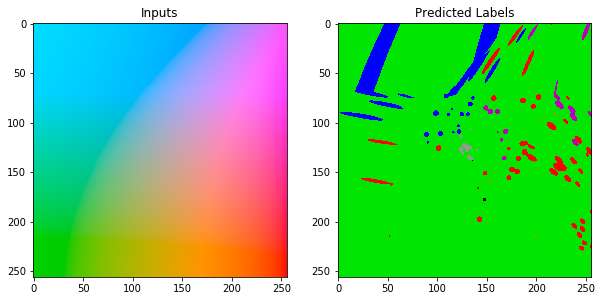

In [15]:
svc_lab_model = make_pipeline(FunctionTransformer(getLabColor), SVC())
svc_lab_model.fit(X_train, y_train)
plot_predictions(svc_lab_model)
plt.show()

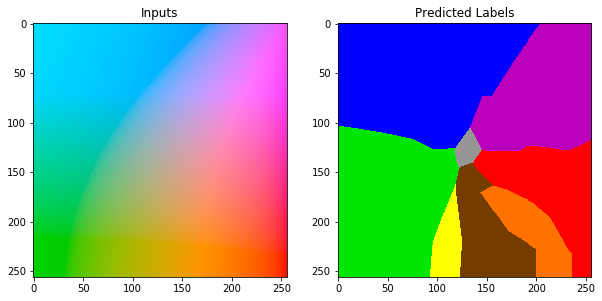

0.699588477366


In [16]:
MLP_lab_model = make_pipeline(FunctionTransformer(pix2lab), 
                              MLPClassifier(
                                  hidden_layer_sizes=(7, 15), 
                                  activation='relu', 
                                  solver='adam', 
                                  alpha=0.0001, 
                                  batch_size='auto', 
                                  learning_rate='constant', 
                                  learning_rate_init=0.001, 
                                  power_t=0.5, max_iter=200, 
                                  shuffle=True, 
                                  random_state=None, 
                                  tol=0.0001, 
                                  verbose=False, 
                                  warm_start=True, 
                                  momentum=0.9, 
                                  nesterovs_momentum=True, 
                                  early_stopping=False, 
                                  validation_fraction=0.1, 
                                  beta_1=0.9, 
                                  beta_2=0.999, 
                                  epsilon=1e-08))
MLP_lab_model.fit(X_train, y_train)
plot_predictions(MLP_lab_model)
plt.show()
y_predicted = MLP_lab_model.predict(X_test)
print(accuracy_score(y_test, y_predicted))

In [2]:
import numpy as np
from skopt import gp_minimize

In [3]:
def f(x):
    return (np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) *
            np.random.randn() * 0.1)

res = gp_minimize(f, [(-2.0, 2.0)])

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:195: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:195: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:195: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:195: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:195: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packa

In [5]:
type(res)

scipy.optimize.optimize.OptimizeResult

In [6]:
res.fun

-0.067332356910355814

In [7]:
res.x

[0.27924186788807615]